# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


# Import the log files
log_file_paths = [
    'Data/Boat_logs/data_AUS.csv',
    'Data/Boat_logs/data_BRA.csv',
    'Data/Boat_logs/data_CAN.csv',
    'Data/Boat_logs/data_DEN.csv',
    'Data/Boat_logs/data_ESP.csv',
    'Data/Boat_logs/data_GBR.csv',
    'Data/Boat_logs/data_GER.csv',
    'Data/Boat_logs/data_ITA.csv',
    'Data/Boat_logs/data_NZL.csv',
    'Data/Boat_logs/data_SUI.csv',
    'Data/Boat_logs/data_USA.csv',
]

log_dataframes = {}     # Dictionary of log files
for file in log_file_paths:
    country = file.replace("Data/Boat_logs/data_", "").replace(".csv", "")  # Extract the country code
    df = pd.read_csv(file) # Read the file
    log_dataframes[country] = df  # Store the logs

# write a function to call that only takes the data after the start of the race

# Load XML File
xml_file_path = "Data/Race_XMLs/25011905_03-13-55.xml"
with open(xml_file_path, "r") as f:
    soup = BeautifulSoup(f, "lxml-xml")  # Use lxml parser

# Parse Course XML
def parse_course_xml(soup):
    """Parses the course XML using BeautifulSoup to extract mark locations and sequence."""
    course_marks = []
    for compound_mark in soup.find_all("CompoundMark"):  # Find all compound marks
        for mark in compound_mark.find_all("Mark"):  # Find all individual marks within compound marks
            course_marks.append({
                'id': int(compound_mark["CompoundMarkID"]),  # Extract the compound mark ID
                'name': mark["Name"],  # Extract the mark name
                'lat': float(mark["TargetLat"]),  # Extract the mark latitude
                'lon': float(mark["TargetLng"])  # Extract the mark longitude
            })
    
    # Extract the ordered sequence of marks based on the course rounding sequence
    sequence = [int(corner["CompoundMarkID"]) for corner in soup.find_all("Corner")]
    
    return course_marks, sequence

marks, sequence = parse_course_xml(soup)


# Distance between two points

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points on the Earth using the Haversine formula."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in meters



def calculate_distance_to_next_mark(log_dataframes, race_number):
    """Calculates the distance to the next mark for each boat and adds it to the dataframe."""
    for country, df in log_dataframes.items():
        race_df = df[df['TRK_RACE_NUM_unk'] == race_number].copy()
        race_df['distance_to_next_mark'] = np.nan  # Initialize the column with NaN values
        
        for i in race_df.index:  # Iterate through each entry in the dataframe
            lat, lon, leg = race_df.loc[i, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk', 'TRK_LEG_NUM_unk']]
            leg = int(leg)  # Convert leg number to integer
            
            if leg < len(sequence):  # Ensure within valid range
                target_mark_id = sequence[leg]  # Get the **next** mark in the sequence
                target_mark = next(m for m in marks if m['id'] == target_mark_id)  # Get correct mark from list
                distance_to_mark = haversine(lat, lon, target_mark['lat'], target_mark['lon'])  # Calculate distance
            else:
                distance_to_mark = 0  # If the boat has finished, set distance to 0
            
            race_df.at[i, 'distance_to_next_mark'] = distance_to_mark  # Store distance in dataframe
        
        log_dataframes[country] = race_df  # Update dataframe in place

# apply once you've extracted the data for one race
def synchronize_boat_data(df):
    """Synchronizes boat data by starting from the index where 'PC_TTS_s' changes from positive to negative."""
    start_index = df[df['PC_TTS_s'] < 0].index.min()
    return df


## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

In [161]:

# calculate a whole downsampled timeseries for use for the rest of the analysis??
# Step 2: Function to calculate circular mean for compass directions
def circular_mean(angles):
    """Compute the circular mean of a series of angles (in degrees)."""
    angles_rad = np.deg2rad(angles.dropna())  # Convert to radians
    sin_mean = np.mean(np.sin(angles_rad))
    cos_mean = np.mean(np.cos(angles_rad))
    mean_angle_rad = np.arctan2(sin_mean, cos_mean)  # Compute mean in radians
    mean_angle_deg = np.rad2deg(mean_angle_rad)  # Convert back to degrees
    return mean_angle_deg % 360  # Ensure the result is within [0, 360]

# Step 3: Function to downsample data
def downsample(df, time_column, direction_column, freq='10S'):
    """
    Downsamples the given dataframe by averaging the specified direction column
    using a circular mean over the given frequency.
    
    Args:
        df: Pandas DataFrame containing the data.
        time_column: Name of the time column (must be in datetime format).
        direction_column: The column with angular data to average.
        freq: Downsampling frequency (default: '10S' for 10 seconds).

    Returns:
        Downsampled DataFrame.
    """
    df[time_column] = pd.to_datetime(df[time_column])  # Ensure time is datetime
    df.set_index(time_column, inplace=True)  # Set time as index

    downsampled_df = df.resample(freq).apply({direction_column: circular_mean})
    
    # Reset index to get time back as a column
    return downsampled_df.reset_index()


#Make a whole downsampled timeseries for each boat 
# Example Usage
# Call a specific dataset by country, e.g., df_AUS = dataframes['AUS']
df_AUS_downsampled = downsample(log_dataframes['SUI'], time_column='TIME_LOCAL_unk', direction_column='HEADING_deg', freq='10S')
print(df_AUS_downsampled.head(10))

       TIME_LOCAL_unk  HEADING_deg
0 2025-01-19 16:06:00    37.006060
1 2025-01-19 16:06:10    60.914908
2 2025-01-19 16:06:20    70.824615
3 2025-01-19 16:06:30    77.440969
4 2025-01-19 16:06:40    87.544429
5 2025-01-19 16:06:50    97.262034
6 2025-01-19 16:07:00   114.610449
7 2025-01-19 16:07:10   116.896025
8 2025-01-19 16:07:20   117.085006
9 2025-01-19 16:07:30    63.519013


C:\Users\fredd\AppData\Local\Temp\ipykernel_7832\589634497.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  downsampled_df = df.resample(freq).apply({direction_column: circular_mean})


## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


Index: 2025-01-19 16:06:01, Heading: 36.5, Speed: 6.12, VMC: 6.051191623902131
Index: 2025-01-19 16:06:02, Heading: 31.98, Speed: 6.67, VMC: 6.497582002474659
Index: 2025-01-19 16:06:03, Heading: 29.32, Speed: 8.1, VMC: 7.8004974768465125
Index: 2025-01-19 16:06:04, Heading: 29.12, Speed: 9.25, VMC: 8.903854134300245
Index: 2025-01-19 16:06:05, Heading: 35.57, Speed: 8.88, VMC: 8.765837353816629
Index: 2025-01-19 16:06:06, Heading: 38.0, Speed: 9.8, VMC: 9.732844504882666
Index: 2025-01-19 16:06:07, Heading: 44.64, Speed: 10.05, VMC: 10.049995938041432
Index: 2025-01-19 16:06:08, Heading: 50.22, Speed: 9.59, VMC: 9.545831596922483
Index: 2025-01-19 16:06:09, Heading: 58.55, Speed: 9.74, VMC: 9.460449770720345
Index: 2025-01-19 16:06:10, Heading: 58.55, Speed: 9.69, VMC: 9.415283387686557
Index: 2025-01-19 16:06:11, Heading: 65.95, Speed: 8.36, VMC: 7.806406680421923
Index: 2025-01-19 16:06:12, Heading: 68.11, Speed: 8.42, VMC: 7.7507747155557185
Index: 2025-01-19 16:06:13, Heading: 70.

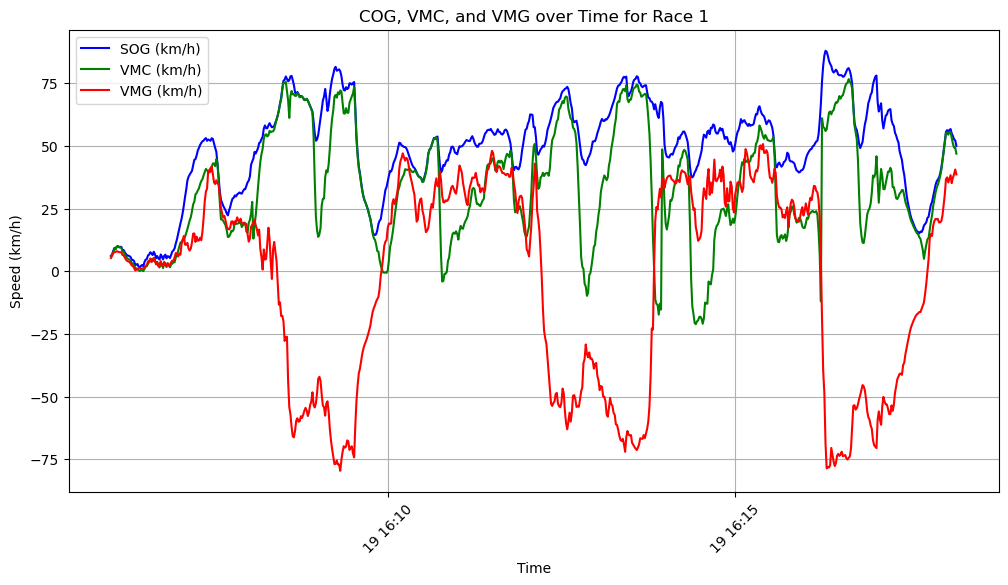

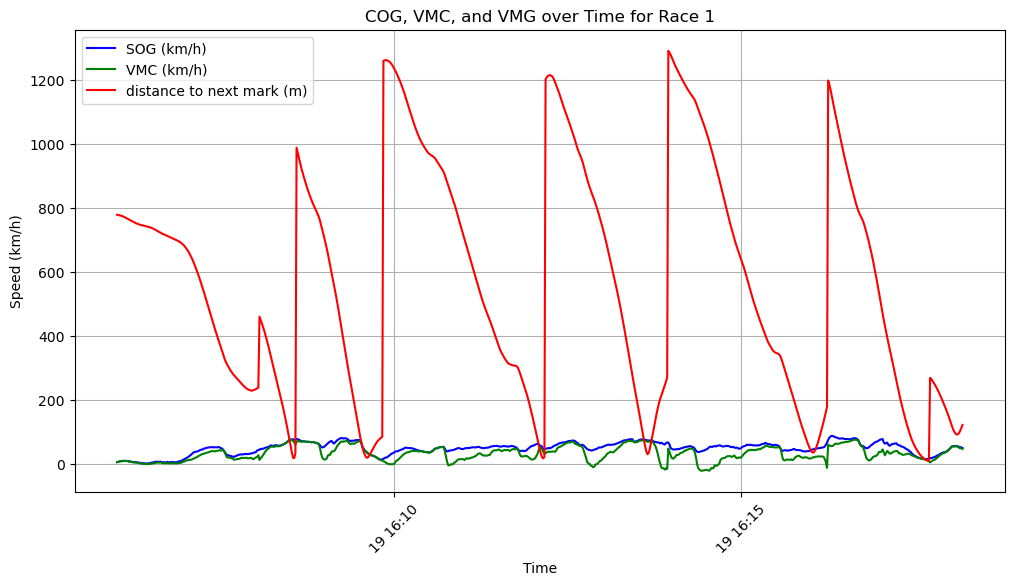

In [162]:
# So this is a combo of the boat lat and lon, as well as the position of the mark in that same time
# Do we need any wind readings at all? 
# Just real mark and boat locations and headings then its basic
# Just trigonometry right?
# maybe do it with the heading on a 10s average rather than 1hz so that it's not so noisy and isn't as much data


import math

def calculate_vmc(df, marks, sequence, race_number):
    """Calculates VMC for each timestamp and updates the dataframe in place."""
    df.loc[df['TRK_RACE_NUM_unk'] == race_number, 'vmc'] = 0.0  # Initialize VMC column only for the selected race
    
    # Filter the DataFrame for the specified race number
    race_df = df[df['TRK_RACE_NUM_unk'] == race_number]
    
    for i in race_df.index:
        lat, lon, heading, speed, leg = df.loc[i, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk', 'GPS_COG_deg', 'GPS_SOG_km_h_1', 'TRK_LEG_NUM_unk']]
        leg = int(leg)  # Ensure LEG_NUMBER is an integer
        
        if leg - 1 < len(sequence):  # Ensure within valid range
            target_mark_id = sequence[leg - 1]  # **Targeting the NEXT mark correctly**
            target_mark = next(m for m in marks if m['id'] == target_mark_id)  # Get correct mark from list
            
            # Compute the bearing from boat to the target mark
            lat1, lon1, lat2, lon2 = map(math.radians, [lat, lon, target_mark['lat'], target_mark['lon']])
            delta_lon = lon2 - lon1
            
            x = math.sin(delta_lon) * math.cos(lat2)
            y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon))
            bearing = math.atan2(x, y)
            
            # Compute mark direction vector using cos/sin of bearing
            mark_vector = np.array([math.sin(bearing), math.cos(bearing)])
            

            # Compute boat velocity vector
            boat_heading_rad = np.radians(heading)  # Convert heading from degrees to radians
            boat_vector = np.array([np.sin(boat_heading_rad), np.cos(boat_heading_rad)])
            
            # Compute VMC as the projection of boat velocity onto the direction to the mark
            vmc = speed * np.dot(boat_vector, -mark_vector)
            df.at[i, 'vmc'] = vmc  # Store VMC value in DataFrame
            
            # Debugging Output to Verify Correct Calculation
            print(f"Index: {i}, Heading: {heading}, Speed: {speed}, VMC: {vmc}")

    return df  # Return the updated dataframe


# Do it for all the boats and for all the race numbers? Make the for loop 
# Use provided log_dataframes['SUI']
race_number = 25011905  # Set the race number to process
boat_tag = 'SUI' # Choose a boat

calculate_distance_to_next_mark(log_dataframes, race_number)  # Compute distance to next mark
log_dataframes[boat_tag] = calculate_vmc(log_dataframes[boat_tag], marks, sequence, race_number)  # Compute VMC for the race



#find indices of start time, when time to start goes to zero PC_TTS_s 
# use the number of total legs in the race and the leg number
# use race number 

# Plot COG, VMC, and VMG over Time
race_df = log_dataframes['SUI'][log_dataframes['SUI']['TRK_RACE_NUM_unk'] == race_number].copy()
#race_df['TIME_LOCAL_unk'] = pd.to_datetime(race_df['TIME_LOCAL_unk'])

plt.figure(figsize=(12, 6))
plt.plot( race_df['GPS_SOG_km_h_1'], label="SOG (km/h)", color="blue")
plt.plot( race_df['vmc'], label="VMC (km/h)", color="green")
plt.plot( race_df['VMG_km_h_1'], label="VMG (km/h)", color="red")

plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.title("COG, VMC, and VMG over Time for Race 1")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()




race_df = log_dataframes['SUI'][log_dataframes['SUI']['TRK_RACE_NUM_unk'] == race_number].copy()
#race_df['TIME_LOCAL_unk'] = pd.to_datetime(race_df['TIME_LOCAL_unk'])

plt.figure(figsize=(12, 6))
plt.plot( race_df['GPS_SOG_km_h_1'], label="SOG (km/h)", color="blue")
plt.plot( race_df['vmc'], label="VMC (km/h)", color="green")
plt.plot( race_df['distance_to_next_mark'], label="distance to next mark (m)", color="red")

plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.title("COG, VMC, and VMG over Time for Race 1")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()



## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.


In [163]:
# Use the straight line runs for this but do for different types of it
#  So we can do just instrument calibration with up and downwind differences and tack to tack but also if there is a certain proximity to the marks we could use the instruments - accounting for wind shear

## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

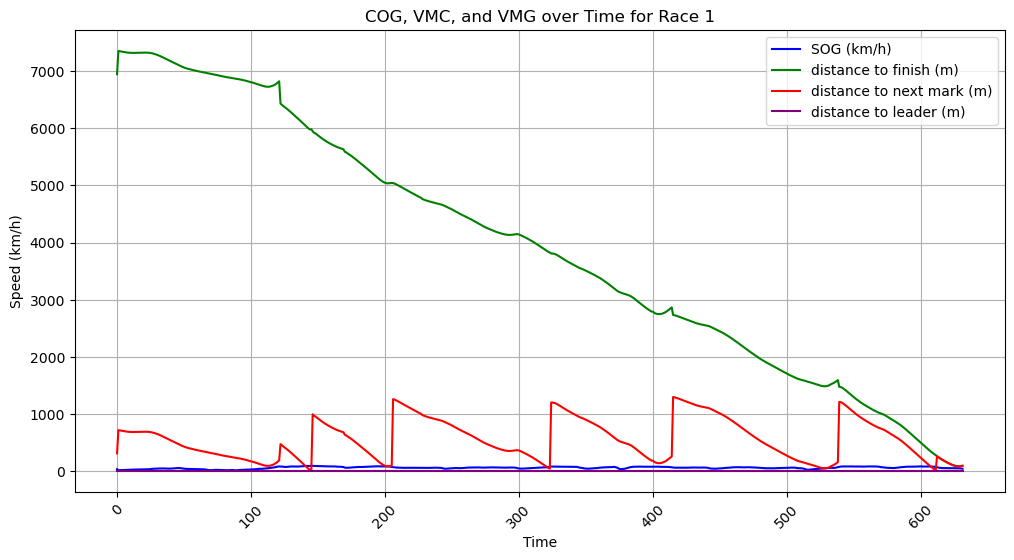

In [164]:
# similar to the VMC calculations but rather than making a coefficient, we just have a distance to each other and then the choice of mark decides the leader
# guessing we use our VMC array
# use real mark positions and log files - we use proximity to the mark rather than the VMC but it may use the same function called distante to mark that wee do for each and then we rank them for each timestep
# once we have a ranking it is a simple substraction to give the distances between VMC lines



def calculate_distance_to_finish(log_dataframes, race_number):
    """Calculates the cumulative distance to the finish line for each boat by summing distances to remaining marks."""
    calculate_distance_to_next_mark(log_dataframes, race_number)
    
    for country, df in log_dataframes.items():
        race_df = df[df['TRK_RACE_NUM_unk'] == race_number].copy()
        distances = []
        for _, row in race_df.iterrows():
            lat, lon, leg = row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk'], int(row['TRK_LEG_NUM_unk'])
            total_distance = 0  # Initialize total distance
            
            # Add distances for all remaining legs, starting from the current leg
            for next_leg in range(leg, len(sequence)):
                next_mark = next(m for m in marks if m['id'] == sequence[next_leg])
                if next_leg == leg:  # First leg: use boat's current position
                    total_distance += haversine(lat, lon, next_mark['lat'], next_mark['lon'])
                else:  # Subsequent legs: use the previous mark's position
                    prev_mark = next(m for m in marks if m['id'] == sequence[next_leg - 1])
                    total_distance += haversine(prev_mark['lat'], prev_mark['lon'], next_mark['lat'], next_mark['lon'])
            
            distances.append(total_distance)
        
        race_df['distance_to_finish'] = distances
        log_dataframes[country] = race_df  # Update the original data structure
    
    return log_dataframes

# change the name to like distance to leader of something
def rank_boats_by_distance(log_dataframes, race_number):
    """Ranks boats based on their distance to the finish line and computes distance to leader for each boat."""
    log_dataframes = calculate_distance_to_finish(log_dataframes, race_number)  # Ensure distances are calculated

    for country, df in log_dataframes.items():
        race_df = df[df['TRK_RACE_NUM_unk'] == race_number].copy()
        race_df = synchronize_boat_data(race_df)
        race_df['distance_to_leader'] = np.nan  # Initialize column for distance to leader

        for time in race_df['DATETIME'].unique():  # Iterate over each timestamp
            snapshot = {country: df[df['DATETIME'] == time] for country, df in log_dataframes.items()}
            snapshot = {k: v for k, v in snapshot.items() if not v.empty}  # Remove empty snapshots

            if snapshot:
                # Rank boats by distance to finish
                ranked_boats = sorted(snapshot.items(), key=lambda x: x[1]['distance_to_finish'].iloc[0])
                leader_distance = ranked_boats[0][1]['distance_to_finish'].iloc[0]  # Get leader's distance

                for rank, (country, boat_data) in enumerate(ranked_boats):
                    if not boat_data.empty:
                        distance_to_leader = boat_data['distance_to_finish'].iloc[0] - leader_distance
                        log_dataframes[country].loc[boat_data.index, 'distance_to_leader'] = distance_to_leader

    return log_dataframes

# Run the calculations
race_number = 25011905  # Specify the race number
#calculate_distance_to_next_mark(log_dataframes, race_number)  # Compute distance to next mark
log_dataframes = rank_boats_by_distance(log_dataframes, race_number)  # Compute DTL




race_df = log_dataframes['AUS'][log_dataframes['AUS']['TRK_RACE_NUM_unk'] == race_number].copy()
#race_df['TIME_LOCAL_unk'] = pd.to_datetime(race_df['TIME_LOCAL_unk'])

plt.figure(figsize=(12, 6))
plt.plot( race_df['GPS_SOG_km_h_1'], label="SOG (km/h)", color="blue")
plt.plot( race_df['distance_to_finish'], label="distance to finish (m)", color="green")
plt.plot( race_df['distance_to_next_mark'], label="distance to next mark (m)", color="red")
plt.plot( race_df['distance_to_leader'], label="distance to leader (m)", color="purple")

plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.title("COG, VMC, and VMG over Time for Race 1")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

In [165]:
# we can use the course wind speed off the marks? Use the boundaries here to stop it deciding to just do two tacks
# lets used a combined mean course wind speed and angle for each leg, choose best VMC angles for each leg and mark when a tack happens.
# how do we initialise it? Calculate the course axis?
# so we need the route of minimum tacks and gybes but also choose which gate, give it the choice based on VMC and also tacks and gybes number
# do we have to assume a tack penalty?
# theoretical marks locations

## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


In [166]:
# standardise everything to absolute value and display red and green?
# twa, sail and twist stuff?
# log file I think
# is this for onboard use? Surely there aren't that many numbers 
# think of unit conversions
# maybe a what if scenario for tacks and gybes, layline distances and times, polar performance


## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

In [167]:
# need to look at the gps trace, turn speed, trim of sails, foil and rudder stuff to compare and contrast
# find best vmg tacks and what they had in common
# iterate through the log files basically to compare all the parameters against performance of a tack
# the file has tacks and gybes, just take the tacks

## Question 8: Give insights on the racing on what made a team win or underperform in the race.

In [168]:
# just a team so go through the log file to and make plots of it all to find moments of shit and moments of good